This notebook esimates FFH using YOLO object detection results from GSV pano images and corresponding depth maps, and conducts assessment of results using ground-truth data.

## Load modules
* Functions on geometry restoration are contained in the geometry.py module.

In [158]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
import numpy as np
import os
import glob
from PIL import Image
from GSV.geometry import extract_feature_pixels_lowest_region, calculate_height_difference, calculate_width_difference, estimate_FFH, estimate_FFE
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from tqdm import tqdm
import pandas as pd

## Set input parameters
* object detection results file
* depth images folder
* ground-truth building points file

In [160]:
# Wagga
# predictions_file=r'C:\Users\lliu\FrontierSI\Projects - 127 Residential Dwelling Floor Height\4 Executing\Data Exploration\GSV\Wagga\YOLO_test\prediction\object_detection_results.csv'
predictions_file=r'C:\Users\lliu\FrontierSI\Projects - 127 Residential Dwelling Floor Height\4 Executing\Data Exploration\GSV\Wagga\YOLO_test\prediction_merged\object_detection_results.csv'
in_folder_depth=r'D:\Wagga\GSV\Depth_clipped'
building_point_file=r'D:\Wagga\GSV\Final_Wagga_meta_camera_height_ground_elevations_gapfill_depth.geojson'

In [161]:
# # Launceston
# predictions_file=r'C:\Users\lliu\FrontierSI\Projects - 127 Residential Dwelling Floor Height\4 Executing\Data Exploration\GSV\Launceston\YOLO_test\prediction\object_detection_results.csv'
# in_folder_depth=r'D:\Launceston\GSV\Depth_clipped'
# building_point_file=r'D:\Launceston\GSV\LC_Final_meta_camera_height_ground_elevations_gapfill_depth.geojson'

## Read in ground-truth building points

In [162]:
gdf=gpd.read_file(building_point_file)
gdf.head()

,WALL_M,STEPS,USAGE,STOREYS,ASSESSOR,address,Area_1,PMF,Dep_500,Dep_200,...,roll,elevation,date,height_c,grd_elev_GSV,grd_elev_building_min,grd_elev_building_mean,grd_elev_building_max,gapfilling_depth,geometry
0,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,721.960449,3.6338,-9999.0000,-9999.0,...,6.252468,181.957260,2019-09,2.373121,178.93782,178.84587,178.96715,179.16086,28.482081,POINT (16402765.937 -4177819.074)
1,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,314.036351,3.4780,-9999.0000,-9999.0,...,NaN,NaN,None,NaN,179.14285,178.90216,179.12869,179.32805,NaN,POINT (16402700.655 -4177810.542)
2,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,1783.805231,3.2973,0.9431,-9999.0,...,NaN,NaN,None,NaN,178.91772,178.35599,178.93541,179.24902,NaN,POINT (16402590.618 -4178082.32)
3,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,346.207850,4.6240,-9999.0000,-9999.0,...,6.254132,181.549530,2019-09,2.824892,179.06947,178.97821,179.10648,179.21405,66.136127,POINT (16402695.386 -4178134.369)
4,Metal,1,Commercial,1,ROBERT,11 MOORONG STREET,615.235606,3.4026,-9999.0000,-9999.0,...,6.249268,181.555573,2019-09,2.439367,179.03090,178.84299,179.06560,179.15392,37.227427,POINT (16402754.627 -4177913.421)


## Read in YOLO object detection results

In [163]:
df_predictions = pd.read_csv(predictions_file)
df_predictions.head()

,class,confidence,pano_id,x1,y1,x2,y2
0,front door,0.924584,--f-ozEFr3g-QueCRiD7wg,1417.0,2050.0,1482.0,2185.0
1,foundation,0.675569,--f-ozEFr3g-QueCRiD7wg,1310.0,2221.0,1794.0,2248.0
2,foundation,0.262738,--f-ozEFr3g-QueCRiD7wg,1294.0,2219.0,1612.0,2240.0
3,garage door,0.949040,--w7nLX9fG5e3-B03RdsCg,3270.0,2071.0,3634.0,2867.0
4,front door,0.921465,-2OAogqaVxTR2MwDTumzyw,1428.0,2005.0,1531.0,2234.0


### Derive top, left, bottom, right coordinates

In [164]:
# Add coordinate pairs
df_predictions["bottom"] = df_predictions.apply(lambda row: {(int(row["x1"]), int(row["y2"])), (int(row["x2"]), int(row["y2"]))}, axis=1)
df_predictions["top"] = df_predictions.apply(lambda row: {(int(row["x1"]), int(row["y1"])), (int(row["x2"]), int(row["y1"]))}, axis=1)
df_predictions["left"] = df_predictions.apply(lambda row: {(int(row["x1"]), int(row["y1"])), (int(row["x1"]), int(row["y2"]))} , axis=1)
df_predictions["right"] = df_predictions.apply(lambda row: {(int(row["x2"]), int(row["y1"])), (int(row["x2"]), int(row["y2"]))} , axis=1)
df_predictions

,class,confidence,pano_id,x1,y1,x2,y2,bottom,top,left,right
0,front door,0.924584,--f-ozEFr3g-QueCRiD7wg,1417.0,2050.0,1482.0,2185.0,"{(1417, 2185), (1482, 2185)}","{(1482, 2050), (1417, 2050)}","{(1417, 2185), (1417, 2050)}","{(1482, 2050), (1482, 2185)}"
1,foundation,0.675569,--f-ozEFr3g-QueCRiD7wg,1310.0,2221.0,1794.0,2248.0,"{(1310, 2248), (1794, 2248)}","{(1310, 2221), (1794, 2221)}","{(1310, 2248), (1310, 2221)}","{(1794, 2248), (1794, 2221)}"
2,foundation,0.262738,--f-ozEFr3g-QueCRiD7wg,1294.0,2219.0,1612.0,2240.0,"{(1294, 2240), (1612, 2240)}","{(1612, 2219), (1294, 2219)}","{(1294, 2240), (1294, 2219)}","{(1612, 2219), (1612, 2240)}"
3,garage door,0.949040,--w7nLX9fG5e3-B03RdsCg,3270.0,2071.0,3634.0,2867.0,"{(3270, 2867), (3634, 2867)}","{(3634, 2071), (3270, 2071)}","{(3270, 2867), (3270, 2071)}","{(3634, 2071), (3634, 2867)}"
4,front door,0.921465,-2OAogqaVxTR2MwDTumzyw,1428.0,2005.0,1531.0,2234.0,"{(1428, 2234), (1531, 2234)}","{(1531, 2005), (1428, 2005)}","{(1428, 2234), (1428, 2005)}","{(1531, 2005), (1531, 2234)}"
...,...,...,...,...,...,...,...,...,...,...,...
3214,garage door,0.965802,_UkrRdpIJ0aiZiZG47hsTA,3.0,2108.0,323.0,2640.0,"{(323, 2640), (3, 2640)}","{(323, 2108), (3, 2108)}","{(3, 2640), (3, 2108)}","{(323, 2640), (323, 2108)}"
3215,garage door,0.953087,_vjy3ZU-W3gE89iYGO2oPw,1901.0,1954.0,2154.0,2095.0,"{(1901, 2095), (2154, 2095)}","{(1901, 1954), (2154, 1954)}","{(1901, 2095), (1901, 1954)}","{(2154, 1954), (2154, 2095)}"
3216,front door,0.285263,_YNcNDdY0S79jpfP6ig0-w,1484.0,1615.0,1527.0,1718.0,"{(1527, 1718), (1484, 1718)}","{(1527, 1615), (1484, 1615)}","{(1484, 1615), (1484, 1718)}","{(1527, 1615), (1527, 1718)}"
3217,front door,0.940072,_Yrg2QNd51ldgD4AxeRSqA,1484.0,2207.0,1586.0,2408.0,"{(1586, 2408), (1484, 2408)}","{(1586, 2207), (1484, 2207)}","{(1484, 2408), (1484, 2207)}","{(1586, 2408), (1586, 2207)}"


#### Get list of pano ids

In [165]:
pano_ids=df_predictions['pano_id'].unique().tolist()

## Test FFH workflow with one example

In [166]:
pano_id=pano_ids[0]
pano_id='xQyZzUB9aD6e9H-dBUJBfw'
pano_id

'xQyZzUB9aD6e9H-dBUJBfw'

### Read in depth map

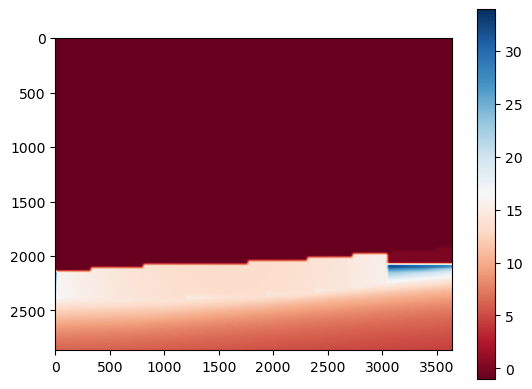

In [167]:
depth_file=os.path.join(in_folder_depth,pano_id+'.tif')
depth_arr=np.asarray(Image.open(depth_file))
H_img = depth_arr.shape[0]  # Height of the cropped panorama
W_img = depth_arr.shape[0]  # Width of the cropped panorama
fig, ax = plt.subplots()
im=ax.imshow(depth_arr,cmap='RdBu', interpolation='none')
fig.colorbar(im)

### Extract building ground elevation, roadway elevation and camera height
* This is only used to estimate FFH from FFE

In [168]:
building_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_building_mean'].values[0]
road_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_GSV'].values[0]
height_camera=gdf.loc[gdf['pano_id'] == pano_id, 'height_c'].values[0]

In [169]:
# extract camera elevation from GSV metadata
# elev_camera=gdf.loc[gdf['pano_id'] == pano_id, 'elevation'].values[0]
# print(elev_camera)
elev_camera=height_camera+road_elevation

### Extract gapfilling depth

In [170]:
depth_gapfill=gdf.loc[gdf['pano_id'] == pano_id, 'gapfilling_depth'].values[0]
depth_gapfill

14.270457768157351

In [171]:
df_single=df_predictions[df_predictions['pano_id']==pano_id]
df_single

,class,confidence,pano_id,x1,y1,x2,y2,bottom,top,left,right
2939,front door,0.910256,xQyZzUB9aD6e9H-dBUJBfw,2538.0,1948.0,2809.0,2217.0,"{(2809, 2217), (2538, 2217)}","{(2538, 1948), (2809, 1948)}","{(2538, 1948), (2538, 2217)}","{(2809, 2217), (2809, 1948)}"
2940,front door,0.856483,xQyZzUB9aD6e9H-dBUJBfw,945.0,1987.0,1086.0,2203.0,"{(945, 2203), (1086, 2203)}","{(945, 1987), (1086, 1987)}","{(945, 1987), (945, 2203)}","{(1086, 1987), (1086, 2203)}"
2941,front door,0.790212,xQyZzUB9aD6e9H-dBUJBfw,1465.0,1966.0,1676.0,2433.0,"{(1676, 2433), (1465, 2433)}","{(1676, 1966), (1465, 1966)}","{(1465, 2433), (1465, 1966)}","{(1676, 2433), (1676, 1966)}"
2942,foundation,0.543295,xQyZzUB9aD6e9H-dBUJBfw,2210.0,2237.0,2829.0,2274.0,"{(2210, 2274), (2829, 2274)}","{(2829, 2237), (2210, 2237)}","{(2210, 2274), (2210, 2237)}","{(2829, 2274), (2829, 2237)}"
2943,stairs,0.331398,xQyZzUB9aD6e9H-dBUJBfw,1408.0,2444.0,1688.0,2505.0,"{(1408, 2505), (1688, 2505)}","{(1688, 2444), (1408, 2444)}","{(1408, 2505), (1408, 2444)}","{(1688, 2444), (1688, 2505)}"


### Calculate feature properties
* Height difference between feature bottom and camera
* Height difference between feature top and camera
* Other metrics for filtering: width, height, area and width/heigh ratio

In [172]:
# Function to compute feature properties 
def compute_feature_properties(row,depth_arr,H_img, W_img,depth_gapfill):
    delta_feature_bottom = calculate_height_difference(row['bottom'], depth_arr, H_img, depth_gapfill=depth_gapfill)
    delta_feature_top = calculate_height_difference(row['top'], depth_arr, H_img, depth_gapfill=depth_gapfill)
    feature_height=delta_feature_top-delta_feature_bottom

    feature_width = calculate_width_difference(row['left'], row['right'], depth_arr, W_img, depth_gapfill=depth_gapfill)

    feature_area=feature_height*feature_width
    dimension_ratio=feature_width/feature_height

    return delta_feature_top, delta_feature_bottom, feature_width, feature_height, feature_area, dimension_ratio

In [ ]:
df_single.loc[:,['delta_feature_top','delta_feature_bottom','width_m', 'height_m','area_m2','ratio']] = df_single.apply(compute_feature_properties,axis=1,
                                                                                                                  args=(depth_arr,H_img,W_img,depth_gapfill),
                                                                                                                  result_type='expand')
df_single

### Filter detected features
* Keep the front door with closest to standard feature metrics
* Keep the lowest and most confident feature for the other classes

In [144]:
# Define real-world target values for Australian front doors
frontdoor_standards = {
    "width_m": 0.82,      # meters
    "height_m": 2.04,     # meters
    "area_m2": 1.67,      # meters²
    "ratio": 0.40         # width-to-height ratio
}
weights = {'width_m': 1, 'height_m': 1, 'area_m2': 1, 'ratio': 1}  # Default weights
classes=["foundation", "front door", "garage door", "stairs"]

In [145]:
def select_best_feature(df):
    selected_rows = []
    for feature_class in classes:
        subset = df[df['class'] == feature_class]
        if subset.empty:
            continue
        if feature_class in ['foundation', 'stairs', 'garage door']:
            # Select by bottom-most, then highest confidence
            best_row = subset.sort_values(by=['y2', 'confidence'], ascending=[False, False]).iloc[0]
        elif feature_class == 'front door':
            # Compute weighted absolute difference
            weighted_diff = (
                weights['width_m'] * abs(subset['width_m'] - frontdoor_standards['width_m']) +
                weights['height_m'] * abs(subset['height_m'] - frontdoor_standards['height_m']) +
                weights['area_m2'] * abs(subset['area_m2'] - frontdoor_standards['area_m2'])+
                weights['ratio'] * abs(subset['ratio'] - frontdoor_standards['ratio'])
            )
            best_row = subset.iloc[np.argmin(weighted_diff)]
        selected_rows.append(best_row)
    
    return pd.DataFrame(selected_rows)

In [146]:
df_single=select_best_feature(df_single)
df_single

,class,confidence,pano_id,x1,y1,x2,y2,bottom,top,left,right,delta_feature_top,delta_feature_bottom,width_m,height_m,area_m2,ratio
2942,foundation,0.543295,xQyZzUB9aD6e9H-dBUJBfw,2210.0,2237.0,2829.0,2274.0,"{(2210, 2274), (2829, 2274)}","{(2829, 2237), (2210, 2237)}","{(2210, 2274), (2210, 2237)}","{(2829, 2274), (2829, 2237)}",-1.034278,-1.236136,2.155071,0.201859,0.435020,10.676132
2941,front door,0.790212,xQyZzUB9aD6e9H-dBUJBfw,1465.0,1966.0,1676.0,2433.0,"{(1676, 2433), (1465, 2433)}","{(1676, 1966), (1465, 1966)}","{(1465, 2433), (1465, 1966)}","{(1676, 2433), (1676, 1966)}",0.447933,-2.100243,0.733374,2.548176,1.868767,0.287804
2943,stairs,0.331398,xQyZzUB9aD6e9H-dBUJBfw,1408.0,2444.0,1688.0,2505.0,"{(1408, 2505), (1688, 2505)}","{(1688, 2444), (1408, 2444)}","{(1408, 2505), (1408, 2444)}","{(1688, 2444), (1688, 2505)}",-2.159772,-2.489160,0.973361,0.329388,0.320614,2.955057


### FFH/FFE Estimation

In [147]:
delta_foundation_bottom = None if len(df_single.loc[df_single['class'] == 'foundation','delta_feature_bottom'])<1 else df_single.loc[df_single['class'] == 'foundation','delta_feature_bottom'].values[0]
delta_stairs_bottom = None if len(df_single.loc[df_single['class'] == 'stairs','delta_feature_bottom'])<1 else df_single.loc[df_single['class'] == 'stairs','delta_feature_bottom'].values[0]
delta_frontdoor_bottom = None if len(df_single.loc[df_single['class'] == 'front door','delta_feature_bottom'])<1 else df_single.loc[df_single['class'] == 'front door','delta_feature_bottom'].values[0]
delta_garagedoor_bottom = None if len(df_single.loc[df_single['class'] == 'garage door','delta_feature_bottom'])<1 else df_single.loc[df_single['class'] == 'garage door','delta_feature_bottom'].values[0]

delta_foundation_top = None if len(df_single.loc[df_single['class'] == 'foundation','delta_feature_top'])<1 else df_single.loc[df_single['class'] == 'foundation','delta_feature_top'].values[0]
delta_stairs_top = None if len(df_single.loc[df_single['class'] == 'stairs','delta_feature_top'])<1 else df_single.loc[df_single['class'] == 'stairs','delta_feature_top'].values[0]

In [148]:
# calculate FFH
FFH = estimate_FFH(delta_foundation_top=delta_foundation_top, 
                   delta_foundation_bottom=delta_foundation_bottom,
                   delta_stairs_top=delta_stairs_top, 
                   delta_stairs_bottom=delta_stairs_bottom, 
                   delta_frontdoor_bottom=delta_frontdoor_bottom,
                   delta_garagedoor_bottom=delta_garagedoor_bottom)
print("Estimated First Floor Height (FFH):", FFH)

Estimated First Floor Height (FFH): 0.3889171594573817


### Gap filling method to calculate FFH using elevations

In [149]:
if FFH is None:
    # calculate FFE
    FFE = estimate_FFE(delta_foundation_top=delta_foundation_top, 
                            delta_stairs_top=delta_stairs_top, 
                            delta_frontdoor_bottom=delta_frontdoor_bottom,
                            delta_garagedoor_bottom=delta_garagedoor_bottom,
                            elev_camera=elev_camera)
    FFH=FFE-building_elevation
    # print("Estimated First Floor Elevation (FFE):", FFE)
    print("Estimated First Floor Height (FFH):", FFH)

In [150]:
gdf[gdf['pano_id']==pano_id]

,WALL_M,STEPS,USAGE,STOREYS,ASSESSOR,address,Area_1,PMF,Dep_500,Dep_200,...,roll,elevation,date,height_c,grd_elev_GSV,grd_elev_building_min,grd_elev_building_mean,grd_elev_building_max,gapfilling_depth,geometry
1232,Brick,2,Commercial,1,NEIL,37 GARDINER STREET,279.717861,5.5721,1.5473,1.1744,...,6.244613,182.478653,2020-11,1.560015,178.98889,178.89116,179.0714,179.34598,14.270458,POINT (16405568.876 -4176366.281)


In [151]:
gdf[gdf['pano_id']==pano_id]['Floor_height']

1232    0.123
Name: Floor_height, dtype: float64

## Batch processing for all images

In [ ]:
min_FFH_all_predicted=[]
mean_FFH_all_predicted=[]
max_FFH_all_predicted=[]
FFE_all_predicted=[]
pano_ids_processed=[] # panos with depth map available
for pano_id in pano_ids:
    df_single=df_predictions[df_predictions['pano_id']==pano_id]
    # read in depth map
    depth_file=os.path.join(in_folder_depth,pano_id+'.tif')
    if os.path.exists(depth_file):
        pano_ids_processed.append(pano_id)
        depth_arr=np.asarray(Image.open(depth_file))
        H_img = depth_arr.shape[0]  # Height of the cropped panorama
        W_img = depth_arr.shape[0]  # Width of the cropped panorama

        # Extract building ground elevation, roadway elevation and camera height
        min_building_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_building_min'].values
        mean_building_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_building_mean'].values
        max_building_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_building_max'].values
        road_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_GSV'].values
        height_camera=gdf.loc[gdf['pano_id'] == pano_id, 'height_c'].values

        if min_building_elevation.size>0 and road_elevation.size>0 and height_camera.size>0:
            elev_camera=height_camera[0]+road_elevation[0]

        # extract gap-filling depth
        depth_gapfill=gdf.loc[gdf['pano_id'] == pano_id, 'gapfilling_depth'].values[0]

        # calculate feature properties
        df_single.loc[:,['delta_feature_top','delta_feature_bottom','width_m', 'height_m','area_m2','ratio']] = df_single.apply(compute_feature_properties,axis=1,
                                                                                                                        args=(depth_arr,H_img,W_img,depth_gapfill),
                                                                                                                        result_type='expand')
        # filter detected features
        df_single=select_best_feature(df_single)

        # FFE/FFH estimation
        delta_foundation_bottom = None if len(df_single.loc[df_single['class'] == 'foundation','delta_feature_bottom'])<1 else df_single.loc[df_single['class'] == 'foundation','delta_feature_bottom'].values[0]
        delta_stairs_bottom = None if len(df_single.loc[df_single['class'] == 'stairs','delta_feature_bottom'])<1 else df_single.loc[df_single['class'] == 'stairs','delta_feature_bottom'].values[0]
        delta_frontdoor_bottom = None if len(df_single.loc[df_single['class'] == 'front door','delta_feature_bottom'])<1 else df_single.loc[df_single['class'] == 'front door','delta_feature_bottom'].values[0]
        delta_garagedoor_bottom = None if len(df_single.loc[df_single['class'] == 'garage door','delta_feature_bottom'])<1 else df_single.loc[df_single['class'] == 'garage door','delta_feature_bottom'].values[0]

        delta_foundation_top = None if len(df_single.loc[df_single['class'] == 'foundation','delta_feature_top'])<1 else df_single.loc[df_single['class'] == 'foundation','delta_feature_top'].values[0]
        delta_stairs_top = None if len(df_single.loc[df_single['class'] == 'stairs','delta_feature_top'])<1 else df_single.loc[df_single['class'] == 'stairs','delta_feature_top'].values[0]

        FFH = estimate_FFH(delta_foundation_top=delta_foundation_top, 
                        delta_foundation_bottom=delta_foundation_bottom,
                        delta_stairs_top=delta_stairs_top, 
                        delta_stairs_bottom=delta_stairs_bottom, 
                        delta_frontdoor_bottom=delta_frontdoor_bottom,
                        delta_garagedoor_bottom=delta_garagedoor_bottom)
        print("Estimated First Floor Height (FFH):", FFH)
        FFH_min=FFH
        FFH_mean=FFH
        FFH_max=FFH
        # if FFH is None:
        # # calculate FFE
        #     FFE = estimate_FFE(delta_foundation_top=delta_foundation_top, 
        #                 delta_stairs_top=delta_stairs_top, 
        #                 delta_frontdoor_bottom=delta_frontdoor_bottom,
        #                 delta_garagedoor_bottom=delta_garagedoor_bottom,
        #                 elev_camera=elev_camera)
        #     if FFE is not None:
        #         FFH_min=FFE-max_building_elevation[0]
        #         FFH_mean=FFE-mean_building_elevation[0]
        #         FFH_max=FFE-min_building_elevation[0]
        #         print("Estimated min First Floor Height (FFH):", FFH_min)
        #         print("Estimated mean First Floor Height (FFH):", FFH_mean)
        #         print("Estimated max First Floor Height (FFH):", FFH_max)
        #         # print("Estimated First Floor Elevation (FFE):", FFE)
        #         FFE_all_predicted.append(FFE)
        min_FFH_all_predicted.append(FFH_min)
        mean_FFH_all_predicted.append(FFH_mean)
        max_FFH_all_predicted.append(FFH_max)
    else:
        print('no depth map exists, skipping...')

In [153]:
# min_FFH_all_predicted=[]
# mean_FFH_all_predicted=[]
# max_FFH_all_predicted=[]
# FFE_all_predicted=[]
# pano_ids=[]
# for pano_id,coords in results.items():
#     # extract pano id
#     depth_file=os.path.join(in_folder_depth,pano_id+'.tif')
#     if os.path.exists(depth_file):
#         pano_ids.append(pano_id)
#         print('pano id: ',pano_id)
#         # read in corresponding depth map
#         depth_arr=np.asarray(Image.open(depth_file))
#         H_img = depth_arr.shape[0]  # Height of the cropped panorama
        
#         # extract elevations of buildings and roadways
#         min_building_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_building_min'].values
#         mean_building_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_building_mean'].values
#         max_building_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_building_max'].values
#         road_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_GSV'].values
#         height_camera=gdf.loc[gdf['pano_id'] == pano_id, 'height_c'].values
#         # extract gapfilling depth
#         depth_gapfill=gdf.loc[gdf['pano_id'] == pano_id, 'gapfilling_depth'].values[0]
        
#         if min_building_elevation.size>0 and road_elevation.size>0 and height_camera.size>0:
#             elev_camera=height_camera[0]+road_elevation[0]
#             # extract bottom pixels of foundation, stairs, front door and garage door
#         foundation_bottom_pixels = {(coords[0]['x1'],coords[0]['y2']),(coords[0]['x2'],coords[0]['y2'])} if coords[0] is not None else None
#         frontdoor_bottom_pixels = {(coords[1]['x1'],coords[1]['y2']),(coords[1]['x2'],coords[1]['y2'])} if coords[1] is not None else None
#         garagedoor_bottom_pixels = {(coords[2]['x1'],coords[2]['y2']),(coords[2]['x2'],coords[2]['y2'])} if coords[2] is not None else None
#         stairs_bottom_pixels = {(coords[3]['x1'],coords[3]['y2']),(coords[3]['x2'],coords[3]['y2'])} if coords[3] is not None else None

#         # extract top pixels of foundation and stairs
#         foundation_top_pixels = {(coords[0]['x1'],coords[0]['y1']),(coords[0]['x2'],coords[0]['y1'])} if coords[0] is not None else None
#         stairs_top_pixels = {(coords[3]['x1'],coords[3]['y1']),(coords[3]['x2'],coords[3]['y1'])} if coords[3] is not None else None

#         # calculate height difference between feature top/bottom and camera
#         delta_foundation_bottom = calculate_height_difference(foundation_bottom_pixels, depth_arr, H_img,depth_gapfill=depth_gapfill)
#         delta_stairs_bottom = calculate_height_difference(stairs_bottom_pixels, depth_arr, H_img,depth_gapfill=depth_gapfill)
#         delta_frontdoor_bottom = calculate_height_difference(frontdoor_bottom_pixels, depth_arr, H_img, depth_gapfill=depth_gapfill)
#         delta_garagedoor_bottom = calculate_height_difference(garagedoor_bottom_pixels, depth_arr, H_img, depth_gapfill=depth_gapfill)
#         delta_foundation_top = calculate_height_difference(foundation_top_pixels, depth_arr, H_img, depth_gapfill=depth_gapfill)
#         delta_stairs_top = calculate_height_difference(stairs_top_pixels, depth_arr, H_img, depth_gapfill=depth_gapfill)
        
#         # calculate FFH
#         FFH = estimate_FFH(delta_foundation_top=delta_foundation_top, 
#                         delta_foundation_bottom=delta_foundation_bottom,
#                         delta_stairs_top=delta_stairs_top, 
#                         delta_stairs_bottom=delta_stairs_bottom, 
#                         delta_frontdoor_bottom=delta_frontdoor_bottom,
#                         delta_garagedoor_bottom=delta_garagedoor_bottom)
#         FFH_min=FFH
#         FFH_mean=FFH
#         FFH_max=FFH
#         # if FFH is None:
#         # # calculate FFE
#         #     FFE = estimate_FFE(delta_foundation_top=delta_foundation_top, 
#         #                 delta_stairs_top=delta_stairs_top, 
#         #                 delta_frontdoor_bottom=delta_frontdoor_bottom,
#         #                 delta_garagedoor_bottom=delta_garagedoor_bottom,
#         #                 elev_camera=elev_camera)
#         #     if FFE is not None:
#         #         FFH_min=FFE-max_building_elevation[0]
#         #         FFH_mean=FFE-mean_building_elevation[0]
#         #         FFH_max=FFE-min_building_elevation[0]
#         #         print("Estimated min First Floor Height (FFH):", FFH_min)
#         #         print("Estimated mean First Floor Height (FFH):", FFH_mean)
#         #         print("Estimated max First Floor Height (FFH):", FFH_max)
#         #         # print("Estimated First Floor Elevation (FFE):", FFE)
#         #         FFE_all_predicted.append(FFE)
#         min_FFH_all_predicted.append(FFH_min)
#         mean_FFH_all_predicted.append(FFH_mean)
#         max_FFH_all_predicted.append(FFH_max)
#     else:
#         print('no depth map exists, skipping...')

## Write estimated FFH/FFE back to building points file

In [154]:
gdf_updated=gdf.copy()
# pano_id_to_FFH=dict(zip(pano_ids_processed, mean_FFH_all_predicted))
# pano_id_to_FFH=dict(zip(pano_ids_processed, min_FFH_all_predicted))
pano_id_to_FFH=dict(zip(pano_ids_processed, max_FFH_all_predicted))
pano_id_to_FFE=dict(zip(pano_ids_processed, FFE_all_predicted))
gdf_updated["FFH_GSV"] = gdf_updated['pano_id'].map(pano_id_to_FFH)
gdf_updated["FFE_GSV"] = gdf_updated['pano_id'].map(pano_id_to_FFE)

In [168]:
out_file=building_point_file.replace('.geojson','_FFH_GSV_YOLO_200ephos_class_merged.geojson')
gdf_updated.to_file(out_file, driver="GeoJSON")

## Regression analysis and accuracy assessment
### FFH

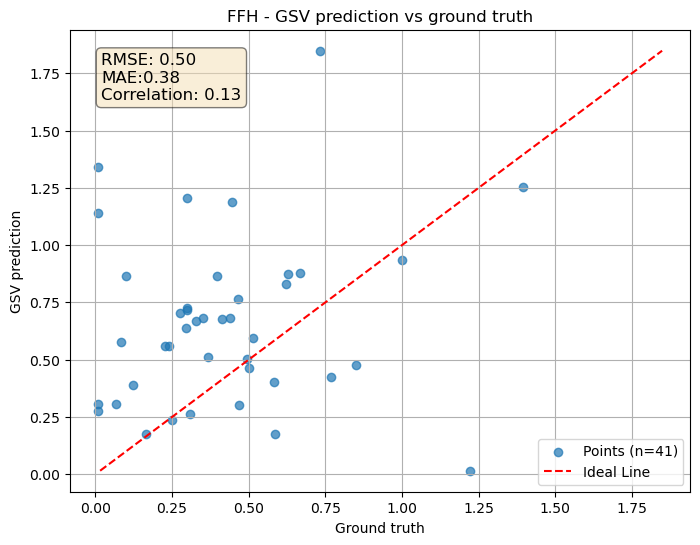

In [156]:
# filter out invalid prediction/groundtruth data
predicted_FFH=gdf_updated["FFH_GSV"]
gt_FFH=gdf_updated["Floor_height"]
# valid_indices = (predicted_FFH>0) &~np.isnan(predicted_FFH) & ~np.isnan(gt_FFH)& (gt_FFH<1.5)
# valid_indices = ~np.isnan(predicted_FFH) & ~np.isnan(gt_FFH) &(predicted_FFH!=0)& (gt_FFH!=0.28)
valid_indices = (predicted_FFH>0) & ~np.isnan(gt_FFH)& (gt_FFH<1.5)& (gt_FFH!=0.28)
predicted_FFH = predicted_FFH[valid_indices]
gt_FFH = gt_FFH[valid_indices]

# Calculate RMSE and MAE
rmse = root_mean_squared_error(gt_FFH, predicted_FFH)
mae=mean_absolute_error(gt_FFH, predicted_FFH)
# Calculate Correlation Coefficient
correlation = np.corrcoef(gt_FFH, predicted_FFH)[0, 1]
# Plot scatter points
plt.figure(figsize=(8, 6))
plt.scatter(gt_FFH, predicted_FFH, alpha=0.7, label=f'Points (n={len(predicted_FFH)})')
# Add a line for ideal correlation (optional)
plt.plot([predicted_FFH.min(), predicted_FFH.max()],[predicted_FFH.min(), predicted_FFH.max()], 'r--', label='Ideal Line')
# Annotate RMSE and Correlation
plt.text(0.05, 0.95, f'RMSE: {rmse:.2f}\nMAE:{mae:.2f}\nCorrelation: {correlation:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle="round", fc="wheat", ec="black", alpha=0.5))
# Labeling
plt.title('FFH - GSV prediction vs ground truth')
plt.xlabel('Ground truth')
plt.ylabel('GSV prediction')
plt.legend()
plt.grid()
# Show plot
plt.show()

In [157]:
gdf_updated[valid_indices][['pano_id','Floor_height','FFH_GSV','gapfilling_depth']]

,pano_id,Floor_height,FFH_GSV,gapfilling_depth
261,gCft75TyAn8aFAnjoqR-Lw,0.276,0.702187,17.623470
263,MG6KZ3XX2q96uvzJ23IIeQ,0.294,0.637558,25.176251
266,MJ4wpamogp7t3JT0YmAxnA,0.502,0.465348,35.748751
268,8L2vOPxI0CYjS8lD7TTI1A,0.414,0.677255,21.303128
270,h1mUE2sMHBtPkQkPWpFUyA,0.084,0.578119,17.423907
271,7wsNZBEi3_wYe0XKOal1ow,0.468,0.304047,21.587087
273,kTsN806wJR3kSkeOhZuJSQ,0.621,0.831711,22.689252
278,--f-ozEFr3g-QueCRiD7wg,0.629,0.873548,36.230608
1065,Sdp4ax7QS6z-NBY_iBH5ww,0.300,1.207639,18.342423
1078,9VNPWl7--7JUSQLu4jGXwQ,0.327,0.667869,20.122260


### FFE

In [ ]:
# # filter out invalid prediction/groundtruth data
# predicted_FFE=gdf_updated["FFE_GSV"]
# gt_FFE=gdf_updated["Floor_Leve"]
# valid_indices = ~np.isnan(predicted_FFE) & ~np.isnan(gt_FFE)
# predicted_FFE = predicted_FFE[valid_indices]
# gt_FFE = gt_FFE[valid_indices]

# # Calculate RMSE and MAE
# rmse_FFE = root_mean_squared_error(gt_FFE, predicted_FFE)
# mae_FFE=mean_absolute_error(gt_FFE, predicted_FFE)
# # Calculate Correlation Coefficient
# correlation_FFE = np.corrcoef(gt_FFE, predicted_FFE)[0, 1]
# # Plot scatter points
# plt.figure(figsize=(8, 6))
# plt.scatter(gt_FFE, predicted_FFE, alpha=0.7, label=f'Points (n={len(predicted_FFE)})')
# # Add a line for ideal correlation (optional)
# plt.plot([predicted_FFE.min(), predicted_FFE.max()],[predicted_FFE.min(), predicted_FFE.max()], 'r--', label='Ideal Line')
# # Annotate RMSE and Correlation
# plt.text(0.05, 0.95, f'RMSE: {rmse_FFE:.2f}\nMAE:{mae_FFE:.2f}\nCorrelation: {correlation_FFE:.2f}', 
#          transform=plt.gca().transAxes, fontsize=12, 
#          verticalalignment='top', bbox=dict(boxstyle="round", fc="wheat", ec="black", alpha=0.5))
# # Labeling
# plt.title('FFH - GSV prediction vs ground truth')
# plt.xlabel('Ground truth')
# plt.ylabel('GSV prediction')
# plt.legend()
# plt.grid()
# # Show plot
# plt.show()